# Bonjour & Bienvenue,

Ce Notebook pédagogique a été créé afin de vous donner un aperçu rapide de mes compétences dans le cadre de ma candidature à votre Master.

Ce simple programme a pour objet de procurer des signaux d'entrées à l'achat et à la vente sur un sous-jacent (exemple par défaut : Indice CAC40) à partir d'indicateurs communs, de tester différents hyperparamètres pour ces indicateurs, de déterminer des stoploss et takeprofit, de les backtester et d'en sortir les indicateurs de performance communément utilisés (Sharpe, Sortino, Calmar, Profitfactor etc.)

## Objectifs pédagogiques

1. Maîtriser les indicateurs communs, leur calcul, leurs inconvénients et avantages
2. Maîtriser les indicateurs de performance communs, leur calcul, leurs inconvénients et avantages
3. Améliorer ses compétences sur les librairies notamment Pandas
4. Créer un mini-système de trading : entrée, sélection du risk-reward, backtesting & performance
5. Casser certaines idées reçues sur la systématicité de stratégies gagnantes seulement basées sur des indicateurs simples

Je me tiens à votre disposition pour répondre à vos questions.
Charles GERARD
c@charlesgerard.fr

In [52]:
# Importation des librairies nécessaires
from __future__ import division

# Modules non importés mais pouvant être utilisés dans une amélioration du programme
# import talib as ta
# from scipy.stats import norm, t
# from sklearn.linear_model import LinearRegression
# from statsmodels.tsa.stattools import adfuller
# import pickle
# import urllib, json
# import mysql.connector
# import smtplib
# import requests


import numpy as np
import os
import time
import pandas as pd
import math 
import warnings

from matplotlib import pyplot as plt
from datetime import datetime
from email.utils import formatdate
from pandas.core.common import SettingWithCopyWarning

np.set_printoptions(suppress=True)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.6f}'.format

# Récupération des données financières

J'ai souscrit un abonnement auprès d'eodhistoricaldata permettant par API de récupérer des données financières sur différents actifs.

Les deux fonctions ci-dessous permettent de récupérer les données historiques (end of day) et la dernière cotation sur un actif.

J'ai mis en place un système de cache afin d'éviter des appels API inutiles.

In [31]:
def getquote(ticker, sfx, force):
    fname='./quotes/'+ticker+sfx+'.csv'
    if os.path.exists(fname) and force!=True:
        d0=pd.read_csv(fname)
        print ticker+sfx+" : from disk"
    else:
        datetime_object = datetime.now()
        url="https://eodhistoricaldata.com/api/eod/"+ticker+sfx+"?api_token=60e9ceff2cd047.71514257&fmt=csv"
        d0=pd.read_csv(url)
        d0=d0.dropna()
        d0.to_csv(fname)
        print ticker+sfx+" : from web"
        time.sleep(2)
    return d0

def getlast(ticker, sfx):
    url="https://eodhistoricaldata.com/api/real-time/"+ticker+sfx+"?api_token=60e9ceff2cd047.71514257&fmt=csv"
    d0=pd.read_csv(url)
    d0=d0.dropna()
    return d0["close"].values

# Calcul des indicateurs

Les fonctions ci-dessous sont utilisées pour calculer les indicateurs et les ajouter au Dataframe Pandas. Certaines de ces fonctions sont inspirées de la librarie TALIB mais réécrites pour les besoins de ce programme.

Les hyperparamètres de ces indicateurs sont passés en paramètres des fonctions.

In [39]:
def normalization(df, n, col1):
    
    # Normalize a column of a dataframe
    
    def func(data):
    
        x = data
            
        return (x[-1] - min(x)) / (max(x) - min(x))

    return df[col1].rolling(n).apply(func).fillna(method="bfill")

def ao(price, period1, period2):
    
    # Awesome Oscillator
    
    median = price.rolling(2).median()
    short = sma(median, period1)
    long = sma(median, period2)
    #ao = short - long
    ao = long - short
    ao_df = pd.DataFrame(ao).rename(columns = {'Close':'ao'})
    return ao_df

def fisher(df,n):
    
    # Fisher
    
    XMAX=df["Adjusted_close"].rolling(n).max()
    XMAX=XMAX.fillna(method="bfill")
    XMIN=df["Adjusted_close"].rolling(n).min()
    XMIN=XMIN.fillna(method="bfill")
    XNEW=(df['Adjusted_close'] - XMIN) / (XMAX - XMIN)
    #X3=X3/100
    XNEW=(2 * XNEW) - 1
    
    dff = pd.DataFrame(columns=['X0'])
    dff["X0"]=XNEW
    
    dff.loc[(dff["X0"]==1), "X0"] = 0.999
    dff.loc[(dff["X0"]==-1), "X0"] = -0.999
    
    XNEW=0.5*np.log( (1+dff["X0"]) / (1-dff["X0"]) )
    

    Xnorm = pd.Series(XNEW, name='Fisher_'+str(n))
    df = df.join(Xnorm)
    
    Xmax = pd.Series(XMAX, name='Xmax_'+str(n))
    df = df.join(Xmax)
    Xmin = pd.Series(XMIN, name='Xmin_'+str(n))
    df = df.join(Xmin)
    return df

def stochastic_oscillator_k(df):
    
    # Stochastic Oscillator %K

    SOk = pd.Series((df['Adjusted_close'] - df['Adjusted_low']) / (df['Adjusted_high'] - df['Adjusted_low']), name='SO%k')
    df = df.join(SOk)
    return df


def stochastic_oscillator_d(df, n):
    
    # Stochastic Oscillator %D
    
    SOk = pd.Series((df['Adjusted_close'] - df['Adjusted_low']) / (df['Adjusted_high'] - df['Adjusted_low']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    df = df.join(SOd)
    return df

def ultimate_oscillator(df, a=7, b=14, c=28):
    
    # Ultimate Oscillator
    
    i = 0
    TR_l = [0]
    BP_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'Adjusted_high'], df.loc[i, 'Adjusted_close']) - min(df.loc[i + 1, 'Adjusted_low'], df.loc[i, 'Adjusted_close'])
        TR_l.append(TR)
        BP = df.loc[i + 1, 'Adjusted_close'] - min(df.loc[i + 1, 'Adjusted_low'], df.loc[i, 'Adjusted_close'])
        BP_l.append(BP)
        i = i + 1
    UltO = pd.Series((4 * pd.Series(BP_l).rolling(a).sum() / pd.Series(TR_l).rolling(a).sum()) + (
                2 * pd.Series(BP_l).rolling(b).sum() / pd.Series(TR_l).rolling(b).sum()) + (
                                 pd.Series(BP_l).rolling(c).sum() / pd.Series(TR_l).rolling(c).sum()),
                     name='Ultimate_Osc')
    df = df.join(UltO)
    return df

def bollinger_bands(df, n, std=2):
    
    # Bollinger Bands
    
    df['TP'] = (df['Adjusted_close'] + df['Adjusted_low'] + df['Adjusted_high'])/3
    df['std'] = df['TP'].rolling(n).std(ddof=0)
    df['MA-TP'] = df['TP'].rolling(n).mean()
    df['BOLU'] = df['MA-TP'] + std*df['std']
    df['BOLD'] = df['MA-TP'] - std*df['std']
    df['BOLW'] = df['BOLU'] - df['BOLD']
    df['BOLW_mean'] = df['BOLW'].rolling(n).mean()
    df['BOLW_std'] = df['BOLW'].rolling(n).std(ddof=0)
    
    return df

def augmented_bollinger_bands(df, n, std=2):
    
    # Augmented Bolllinger Bands
    
    df['A_MA-TPH'] = df['Adjusted_high'].ewm(span=n, adjust=False).mean()
    df['A_MA-TPL'] = df['Adjusted_low'].ewm(span=n, adjust=False).mean()
    
    df['A_stdh'] = df['A_MA-TPH'].rolling(n).std(ddof=0)
    df['A_stdl'] = df['A_MA-TPL'].rolling(n).std(ddof=0)
    
    df['A_BOLU'] = df['A_MA-TPH'] + std*df['A_stdh']
    df['A_BOLD'] = df['A_MA-TPL'] - std*df['A_stdl']
    
    df['A_BOLW'] = df['A_BOLU'] - df['A_BOLD']
    df['A_BOLW_mean'] = df['A_BOLW'].rolling(n).mean()
    df['A_BOLW_std'] = df['A_BOLW'].rolling(n).std(ddof=0)
    return df

def relative_strength_index(df, n, f1="Adjusted_high", f2="Adjusted_low"):
    
    # Relative Strength Index(RSI)
    
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, f1] - df.loc[i, f1]
        DoMove = df.loc[i, f2] - df.loc[i + 1, f2]
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    return df

def dynamic_relative_strength_index(df, n):
    
    # Dynamic Relative Strength Index(RSI)
    
    df1=df.copy()
    
    df1['STD10_h']=df1['Adjusted_high'].rolling(10).std()
    df1['STD10_l']=df1['Adjusted_low'].rolling(10).std()
    
    df1=relative_strength_index(df1, 10, "STD10_h", "STD10_l")
    df1["RSI_10"]=df1["RSI_10"].fillna(method="bfill")
    
    df1=relative_strength_index(df1, 2)
    df1=relative_strength_index(df1, 3)
    df1=relative_strength_index(df1, 5)
    df1=relative_strength_index(df1, 8)
    df1=relative_strength_index(df1, 13)
    df1=relative_strength_index(df1, 21)
    df1=relative_strength_index(df1, 34)
    df1=relative_strength_index(df1, 55)
    df1=relative_strength_index(df1, 89)
    df1=relative_strength_index(df1, 144)
    
    df1["DyRSI_10"]=0
    
    for i1, r1 in df1.iterrows():
        if r1["RSI_10"] >= 0 and r1["RSI_10"] <= 0.10 :
            df1.loc[i1, 'DyRSI_10'] = r1["RSI_144"]
            
        if r1["RSI_10"] > 0.10 and r1["RSI_10"] <= 0.20 :
             df1.loc[i1, 'DyRSI_10'] = r1["RSI_89"]
            
        if r1["RSI_10"] > 0.20 and r1["RSI_10"] <= 0.30 :
             df1.loc[i1, 'DyRSI_10'] = r1["RSI_55"]
            
        if r1["RSI_10"] > 0.30 and r1["RSI_10"] <= 0.40 :
             df1.loc[i1, 'DyRSI_10'] = r1["RSI_34"]
            
        if r1["RSI_10"] > 0.40 and r1["RSI_10"] <= 0.50 :
             df1.loc[i1, 'DyRSI_10'] = r1["RSI_21"]
            
        if r1["RSI_10"] > 0.50 and r1["RSI_10"] <= 0.60 :
             df1.loc[i1, 'DyRSI_10'] = r1["RSI_13"]
            
        if r1["RSI_10"] > 0.60 and r1["RSI_10"] <= 0.70 :
             df1.loc[i1, 'DyRSI_10'] = r1["RSI_8"]
            
        if r1["RSI_10"] > 0.70 and r1["RSI_10"] <= 0.80 :
             df1.loc[i1, 'DyRSI_10'] = r1["RSI_5"]
            
        if r1["RSI_10"] > 0.80 and r1["RSI_10"] <= 0.90 :
             df1.loc[i1, 'DyRSI_10'] = r1["RSI_3"]
            
        if r1["RSI_10"] > 0.90 and r1["RSI_10"] <= 0.100 :
             df1.loc[i1, 'DyRSI_10'] = r1["RSI_2"]
            
    df1["DyRSI_10"]=df1["DyRSI_10"].fillna(method="bfill")
    df["DyRSI_10"]=df1["DyRSI_10"]
    return df

def moving_average(df, n):
    
    # Simple Moving Average

    df.drop(columns=['MA_' + str(n)], errors='ignore', inplace=True)
    MA = pd.Series(df['Adjusted_close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    df['MA_' + str(n)]=df['MA_' + str(n)].fillna(method="bfill")
    
    df['MA_' + str(n)+'_dm1']=df['MA_' + str(n)].shift(1)
    df['MA_' + str(n)+'_dm1']=df['MA_' + str(n)+'_dm1'].fillna(method="bfill")
    
    return df

def mcginley_average(df, n):

    # McGinley Moving Average
    
    df.drop(columns=['MGMA_' + str(n)], errors='ignore', inplace=True)
    df['MGMA_'+str(n)]=0
    
    for index, row in df.iterrows():
        if index==0 or df.at[index-1,'MGMA_'+str(n)]==0:
            df.at[index,'MGMA_'+str(n)]=row['Adjusted_close']
        else:
            df.at[index,'MGMA_'+str(n)]=df.at[index-1,'MGMA_'+str(n)] + ( (row['Adjusted_close'] - df.at[index-1,'MGMA_'+str(n)]) / (0.6 * n * (row['Adjusted_close'] / df.at[index-1,'MGMA_'+str(n)])**4 ) )
    
    df['MGMA_' + str(n)]=df['MGMA_' + str(n)].fillna(method="bfill")
    
    df['MGMA_' + str(n)+'_dm1']=df['MGMA_' + str(n)].shift(1)
    df['MGMA_' + str(n)+'_dm1']=df['MGMA_' + str(n)+'_dm1'].fillna(method="bfill")
    
    return df

def exponential_moving_average(df, n, col='Adjusted_close'):
    
    # Exponential Moving Average
    
    df.drop(columns=['EMA_' + str(n)], errors='ignore', inplace=True)
    EMA = pd.Series(df[col].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    df = df.join(EMA)
    
    df['EMA_' + str(n)]=df['EMA_' + str(n)].fillna(method="bfill")
    
    df['EMA_' + str(n)+'_dm1']=df['EMA_' + str(n)].shift(1)
    df['EMA_' + str(n)+'_dm1']=df['EMA_' + str(n)+'_dm1'].fillna(method="bfill")
    
    return df

def hull_moving_average(df, n, col='Adjusted_close'):
    
    # Hull Moving Average
    
    df.drop(columns=['HMA_' + str(n)], errors='ignore', inplace=True)
    
    SMA1 = df[col].rolling(n).mean()
    SMA2 = df[col].rolling(int(n/2)).mean()
    HMA0 = (2 * SMA2 - SMA1).rolling(int(np.sqrt(n))).mean()
    
    HMA = pd.Series(HMA0, name='HMA_' + str(n))
    df = df.join(HMA)
    
    df['HMA_' + str(n)]=df['HMA_' + str(n)].fillna(method="bfill")
    
    df['HMA_' + str(n)+'_dm1']=df['HMA_' + str(n)].shift(1)
    df['HMA_' + str(n)+'_dm1']=df['HMA_' + str(n)+'_dm1'].fillna(method="bfill")
    
    return df

def SSMA(df, n = 9, adjust = True, col='Adjusted_close'):
    
    # Smoothed Simple Moving Average

    df.drop(columns=['SMA_' + str(n)], errors='ignore', inplace=True)
    SMA = pd.Series(df[col].ewm(ignore_na=False, alpha=1.0 / n, min_periods=0, adjust=adjust).mean(), name='SMA_' + str(n))
    df = df.join(SMA)
    
    df['SMA_' + str(n)]=df['SMA_' + str(n)].fillna(method="bfill")
    
    df['SMA_' + str(n)+'_dm1']=df['SMA_' + str(n)].shift(1)
    df['SMA_' + str(n)+'_dm1']=df['SMA_' + str(n)+'_dm1'].fillna(method="bfill")
    
    return df

def TRIMA(df, n=18, col='Adjusted_close'):
    
    # Triangular Moving Average (TRIMA)
    
    df.drop(columns=['TRIMA_' + str(n)], errors='ignore', inplace=True)
    MA = pd.Series(df[col].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    
    SMA = MA.rolling(window=n).sum()
    TRIMA=pd.Series(SMA / n, name='TRIMA_' + str(n))
    df = df.join(TRIMA)
    
    df['TRIMA_' + str(n)]=df['TRIMA_' + str(n)].fillna(method="bfill")
    
    df['TRIMA_' + str(n)+'_dm1']=df['TRIMA_' + str(n)].shift(1)
    df['TRIMA_' + str(n)+'_dm1']=df['TRIMA_' + str(n)+'_dm1'].fillna(method="bfill")
    
    return df

def TR(df):
    
    # True Range

    TR1 = pd.Series(df["Adjusted_high"] - df["Adjusted_low"]).abs()  # True Range = High less Low

    TR2 = pd.Series(
        df["Adjusted_high"] - df["Adjusted_close"].shift()
    ).abs()  # True Range = High less Previous Close

    TR3 = pd.Series(
        df["Adjusted_close"].shift() - df["Adjusted_low"]
    ).abs()  # True Range = Previous Close less Low

    _TR = pd.concat([TR1, TR2, TR3], axis=1)

    _TR["TR"] = _TR.max(axis=1)

    TR=pd.Series(_TR["TR"], name='TR')
    df = df.join(TR)
    
    return df

def ATR(df, n = 14, typeatr=0):
    
    # Average True Range

    df.drop(columns=['ATR_' + str(n)], errors='ignore', inplace=True)
    
    if typeatr==0:
        ATR = pd.Series(df["TR"].ewm(span=n, min_periods=n).mean(), name='ATR_' + str(n))
    elif typeatr==1:
        ATR = pd.Series(df["TR"].ewm(ignore_na=False, alpha=1.0 / n, min_periods=0, adjust=True).mean(), name='ATR_' + str(n))
    else:
        ATR = pd.Series(df["TR"].rolling(center=False, window=n).mean(), name='ATR_' + str(n))
        
    df = df.join(ATR)
    
    df['ATR_' + str(n)]=df['ATR_' + str(n)].fillna(method="bfill")
    
    df['ATR_' + str(n)+'_dm1']=df['ATR_' + str(n)].shift(1)
    df['ATR_' + str(n)+'_dm1']=df['ATR_' + str(n)+'_dm1'].fillna(method="bfill")
    
    return df

def DMI(df, period = 14, adjust = True):
    
    # Directional Movement Indicator or Directional Movement Index

    df["up_move"] = df["Adjusted_high"].diff()
    df["down_move"] = -df["Adjusted_low"].diff()

    # positive Dmi
    def _dmp(row):
        if row["up_move"] > row["down_move"] and row["up_move"] > 0:
            return row["up_move"]
        else:
            return 0

    # negative Dmi
    def _dmn(row):
        if row["down_move"] > row["up_move"] and row["down_move"] > 0:
            return row["down_move"]
        else:
            return 0

    df["plus"] = df.apply(_dmp, axis=1)
    df["minus"] = df.apply(_dmn, axis=1)

    df["DMIPLUS"] =  100* (df["plus"] / df['ATR_'+str(period)]).ewm(alpha=1 / period, adjust=adjust).mean()
    df["DMIMINUS"] = 100 * (df["minus"] / df['ATR_'+str(period)]).ewm(alpha=1 / period, adjust=adjust).mean()

    return df

def ADX(df, period = 14, adjust = True):
    
    # ADX

    df = DMI(df, period)
    
    df["ADX_"+str(period)]=100 * (abs(df["DMIPLUS"] - df["DMIMINUS"]) / (df["DMIPLUS"] + df["DMIMINUS"])).ewm(alpha=1 / period, adjust=adjust).mean()
    df['ADX_' + str(period)]=df['ADX_' + str(period)].fillna(method="bfill")
    
    return df


def supertrend(df, n = 14, multiplier=2, supertrendtype=0):
    
    # SuperTrend

    df.drop(columns=['SuperTrend_' + str(n) + "_" + str(multiplier)], errors='ignore', inplace=True)
    
    df=ATR(df,n, supertrendtype)
    
    
    df["SuperTrend_BasicUB"]=( (df["Adjusted_high"]+df["Adjusted_low"]) / 2 ) + (multiplier * df["ATR_"+str(n)])
    df["SuperTrend_BasicLB"]=( (df["Adjusted_high"]+df["Adjusted_low"]) / 2 ) - (multiplier * df["ATR_"+str(n)])
    
    df['SuperTrend_BasicUB_dm1']=df['SuperTrend_BasicUB'].shift(1)
    df['SuperTrend_BasicUB_dm1']=df['SuperTrend_BasicUB'+'_dm1'].fillna(method="bfill")
    
    df['SuperTrend_BasicLB_dm1']=df['SuperTrend_BasicLB'].shift(1)
    df['SuperTrend_BasicLB_dm1']=df['SuperTrend_BasicLB'+'_dm1'].fillna(method="bfill")
    
    df["SuperTrend_FinalUB"]=0.0000
    df["SuperTrend_FinalLB"]=0.0000
    df['SuperTrend_' + str(n) + "_" + str(multiplier)]=0.0000
    
    lastub=0
    lastlb=0
    previoussupertrend=0
    
    for index, row in df.iterrows():
        if index==0:
            df.at[index,"SuperTrend_FinalUB"]=0
            lastub=0
            df.at[index,"SuperTrend_FinalLB"]=0
            lastlb=0
        else:
            if row["SuperTrend_BasicUB"] < lastub or row["Adjusted_close_dm1"] > lastub:
                df.at[index,"SuperTrend_FinalUB"]=row["SuperTrend_BasicUB"]
                lastub=row["SuperTrend_BasicUB"]
            else:
                df.at[index,"SuperTrend_FinalUB"]=lastub
            
            if row["SuperTrend_BasicLB"] > lastlb or row["Adjusted_close_dm1"] < lastlb:
                df.at[index,"SuperTrend_FinalLB"]=row["SuperTrend_BasicLB"]
                lastlb=row["SuperTrend_BasicLB"]
            else:
                df.at[index,"SuperTrend_FinalLB"]=lastlb

    df['SuperTrend_FinalLB_dm1']=df['SuperTrend_FinalLB'].shift(1)
    df['SuperTrend_FinalLB_dm1']=df['SuperTrend_FinalLB'+'_dm1'].fillna(method="bfill")
    
    df['SuperTrend_FinalUB_dm1']=df['SuperTrend_FinalUB'].shift(1)
    df['SuperTrend_FinalUB_dm1']=df['SuperTrend_FinalUB'+'_dm1'].fillna(method="bfill")
    
    for index, row in df.iterrows():
        if index==0:
            df.at[index,'SuperTrend_' + str(n) + "_" + str(multiplier)]=0
            previoussupertrend=0
        elif previoussupertrend==row["SuperTrend_FinalUB_dm1"] and row["Adjusted_close"]<=row['SuperTrend_FinalUB']:
            df.at[index,'SuperTrend_' + str(n) + "_" + str(multiplier)]=row["SuperTrend_FinalUB"]
            previoussupertrend=row["SuperTrend_FinalUB"]
        elif previoussupertrend==row["SuperTrend_FinalUB_dm1"] and row["Adjusted_close"]>row['SuperTrend_FinalUB']:
            df.at[index,'SuperTrend_' + str(n) + "_" + str(multiplier)]=row["SuperTrend_FinalLB"]
            previoussupertrend=row["SuperTrend_FinalLB"]
        elif previoussupertrend==row["SuperTrend_FinalLB_dm1"] and row["Adjusted_close"]>=row['SuperTrend_FinalLB']:
            df.at[index,'SuperTrend_' + str(n) + "_" + str(multiplier)]=row["SuperTrend_FinalLB"]
            previoussupertrend=row["SuperTrend_FinalLB"]
        elif previoussupertrend==row["SuperTrend_FinalLB_dm1"] and row["Adjusted_close"]<row['SuperTrend_FinalLB']:
            df.at[index,'SuperTrend_' + str(n) + "_" + str(multiplier)]=row["SuperTrend_FinalUB"]
            previoussupertrend=row["SuperTrend_FinalUB"]
            
    df['SuperTrend_' + str(n) + "_" + str(multiplier)+'_dm1']=df['SuperTrend_' + str(n) + "_" + str(multiplier)].shift(1)
    df['SuperTrend_' + str(n) + "_" + str(multiplier)+'_dm1']=df['SuperTrend_' + str(n) + "_" + str(multiplier)+'_dm1'].fillna(method="bfill")
    
    return df

def macd(df, period_fast=12, period_slow=26, period_signal=9, macdtype='EMA'):
    
    # MACD
    
    if macdtype=='EMA':
        df=exponential_moving_average(df, period_fast)
        df=exponential_moving_average(df, period_slow)
        df["MACDLine"]=df["EMA_"+str(period_fast)]-df["EMA_"+str(period_slow)]
        df=exponential_moving_average(df, period_signal, 'MACDLine')
        df["MACDSignal"]=df["EMA_"+str(period_signal)]
    elif macdtype=='SMA':
        df=SSMA(df, period_fast)
        df=SSMA(df, period_slow)
        df["MACDLine"]=df["SMA_"+str(period_fast)]-df["SMA_"+str(period_slow)]
        df=SSMA(df, period_signal, True, 'MACDLine')
        df["MACDSignal"]=df["SMA_"+str(period_signal)]
    elif macdtype=='TRIMA':
        df=TRIMA(df, period_fast)
        df=TRIMA(df, period_slow)
        df["MACDLine"]=df["TRIMA_"+str(period_fast)]-df["TRIMA_"+str(period_slow)]
        df=TRIMA(df, period_signal, 'MACDLine')
        df["MACDSignal"]=df["TRIMA_"+str(period_signal)]
    else:
        df=exponential_moving_average(df, period_fast)
        df=exponential_moving_average(df, period_slow)
        df["MACDLine"]=df["EMA_"+str(period_fast)]-df["EMA_"+str(period_slow)]
        df=exponential_moving_average(df, period_signal, 'MACDLine')
        df["MACDSignal"]=df["EMA_"+str(period_signal)]
        
    df['MACDLine' + '_dm1']=df['MACDLine'].shift(1)
    df['MACDLine' + '_dm1']=df['MACDLine' + '_dm1'].fillna(method="bfill")
    df['MACDSignal' + '_dm1']=df['MACDSignal'].shift(1)
    df['MACDSignal' + '_dm1']=df['MACDSignal' + '_dm1'].fillna(method="bfill")
    
    return df



# Preprocessing

La fonction ci-dessous est utilisée pour préprocesser notre dataframe (ajustement des cotations, calculs des True Range, Average True Range, ADX et DMI

In [40]:
def preprocess(df):
    coef=df["Adjusted_close"]/df["Close"]
    df["Adjusted_open"]=df["Open"]*coef
    df["Adjusted_high"]=df["High"]*coef
    df["Adjusted_low"]=df["Low"]*coef

    df["Adjusted_close_dm1"]=df["Adjusted_close"].shift(1)
    df['Adjusted_close_dm1']=df['Adjusted_close_dm1'].fillna(method="bfill")
    
    df=TR(df)
    df=ATR(df)
    df=ADX(df)
    
    return df

# Signaux

Les fonctions ci-dessous permettent de définir les différents signaux qui seront utilisés.

Par exemple : croisement d'un indicateur avec un prix, croisement de deux ou trois indicateurs, franchissement de seuils etc.

In [41]:
def signal_1(df, col1):
    # Cross IND x PRICE
    df["Signal"]=0
    
    df.loc[(df['Adjusted_close']>=df[col1]) & (df['Adjusted_close_dm1']<df[col1+'_dm1']), "Signal"] = 1
    df.loc[(df['Adjusted_close']<=df[col1]) & (df['Adjusted_close_dm1']>df[col1+'_dm1']), "Signal"] = -1
    
    return df

def signal_2(df, col1, col2):
    # Cross IND 1 x IND 2
    df["Signal"]=0
    
    df.loc[(df[col1]>=df[col2]) & (df[col1+'_dm1']<df[col2+'_dm1']), "Signal"] = 1
    df.loc[(df[col1]<=df[col2]) & (df[col1+'_dm1']>df[col2+'_dm1']), "Signal"] = -1
    
    return df

def signal_3(df, col1, col2, col3):
    # Cross IND 1 x IND 2 x IND3
    df["Signal"]=0
    
    df.loc[(df[col1]>=df[col2]) & (df[col1]>=df[col3]) & (df[col1+'_dm1']<df[col2+'_dm1']), "Signal"] = 1
    df.loc[(df[col1]<=df[col2]) & (df[col1]<=df[col3]) & (df[col1+'_dm1']>df[col2+'_dm1']), "Signal"] = -1
    
    return df

def signal_4(df, col1):
    # DISTANCE IND x PRICE
    df["Signal"]=0
    
    df.loc[(df[col1]==0), "Signal"] = 1
    df.loc[(df[col1]==1), "Signal"] = -1
    
    return df

def signal_5(df, col1, col2):
    # CROSS 2 IND
    df["Signal"]=0
    
    df.loc[(df[col1]>=df[col2]) & (df[col1+'_dm1']<df[col2+'_dm1']), "Signal"] = 1
    df.loc[(df[col1]<=df[col2]) & (df[col1+'_dm1']>df[col2+'_dm1']), "Signal"] = -1
    
    return df

def signal_6(df, col1):
    # CROSS <> 0
    df["Signal"]=0
    
    df.loc[(df[col1]>=0) & (df[col1+'_dm1']<0), "Signal"] = 1
    df.loc[(df[col1]<0) & (df[col1+'_dm1']>0), "Signal"] = -1
    
    return df

# Backtesting & Performance

La fonction ci-dessous a pour objectif de backtester une stratégie en fonction :

- de la colonne Signal
- de notre souhait de balance risk/reward
- de l'ATR souhaité pour le calcul des Stoploss & TakeProfit

Une position est fermée soit lorsqu'un stoploss ou un takeprofit est touché soit lorsqu'un signal inverse est envoyé.

Cette fonction permet également d'établir un benchmark qui est la fameuse stratégie Buy & Hold qui servira de 

A la fin de cette fonction, on calcule les indicateurs de performance de la stratégie étudiée.

In [49]:
def backtesting(df, risk=1, reward=2, atr=14):
    benchmark_q=0
    benchmark_p=0
    benchmark_c=0

   
    trades_c=1000
    trades_q=0
    trades_p=0
    trades_tp=0
    trades_sl=0
    trades_adx=0
    
    hold=0
    last=0
    
    # Sens Entrée Sortie Quantité P&L TakeProfit Stoploss ADX
    trades=[]
    capital=[]
    benchmark=[]
    
    for index, row in df.iterrows():
        if benchmark_p==0:
            # On intialise le Benchmark
            benchmark_p=row['Adjusted_close']
            benchmark_q=trades_c/row['Adjusted_close']
        
        benchmark.append(benchmark_q*row['Adjusted_close'])
        
        if hold==0:
            capital.append(trades_c)
        else:
            if hold==-1:
                benef=(trades_p*trades_q)-(row['Adjusted_close']*trades_q)
                capital.append(trades_c+benef)
            else:
                benef=(row['Adjusted_close']*trades_q)-(trades_p*trades_q)
                capital.append(trades_c+benef)
        
        if hold==0:
            # Ouverture d'une position
            if row['Signal']>0:
                hold=1
                trades_q=trades_c/row['Adjusted_close']
                trades_p=row['Adjusted_close']
                trades_tp=trades_p+reward*row['ATR_'+str(atr)]
                trades_sl=trades_p-risk*row['ATR_'+str(atr)]
                trades_adx=row['ADX_'+str(atr)]
            if row['Signal']<0:
                hold=-1
                trades_q=trades_c/row['Adjusted_close']
                trades_p=row['Adjusted_close']
                trades_tp=trades_p-reward*row['ATR_'+str(atr)]
                trades_sl=trades_p+risk*row['ATR_'+str(atr)]
                trades_adx=row['ADX_'+str(atr)]
        else:
            if row['Signal']!=hold:
                # Fermeture d'une position
                if row['Signal']>0:
                    if (reward > 0) & (risk > 0):
                        if (row['Adjusted_high']>=trades_sl):
                            benef=(trades_p*trades_q)-(trades_sl*trades_q)
                            trade_tmp=[-1, trades_p, trades_sl, trades_q, benef, trades_tp, trades_sl, trades_adx]
                        elif (row['Adjusted_low']<=trades_tp):
                            benef=(trades_p*trades_q)-(trades_tp*trades_q)
                            trade_tmp=[-1, trades_p, trades_tp, trades_q, benef, trades_tp, trades_sl, trades_adx]
                        else:
                            benef=(trades_p*trades_q)-(row['Adjusted_close']*trades_q)
                            trade_tmp=[-1, trades_p, row['Adjusted_close'], trades_q, benef, trades_tp, trades_sl, trades_adx]
                    else:
                        benef=(trades_p*trades_q)-(row['Adjusted_close']*trades_q)
                        trade_tmp=[-1, trades_p, row['Adjusted_close'], trades_q, benef, trades_tp, trades_sl, trades_adx]
                    
                    trades.append(trade_tmp)
                    trades_c+=benef
                    hold=1
                    trades_q=trades_c/row['Adjusted_close']
                    trades_p=row['Adjusted_close']
                    trades_tp=trades_p+reward*row['ATR_'+str(atr)]
                    trades_sl=trades_p-risk*row['ATR_'+str(atr)]
                    trades_adx=row['ADX_'+str(atr)]
                if row['Signal']<0:
                    if (reward > 0) & (risk > 0):
                        if (row['Adjusted_low']<=trades_sl):
                            benef=(trades_sl*trades_q)-(trades_p*trades_q)
                            trade_tmp=[1, trades_p, trades_sl, trades_q, benef, trades_tp, trades_sl, trades_adx]
                        elif (row['Adjusted_high']>=trades_tp):
                            benef=(trades_tp*trades_q)-(trades_p*trades_q)
                            trade_tmp=[1, trades_p, trades_tp, trades_q, benef, trades_tp, trades_sl, trades_adx]
                        else:
                            benef=(row['Adjusted_close']*trades_q)-(trades_p*trades_q)
                            trade_tmp=[1, trades_p, row['Adjusted_close'], trades_q, benef, trades_tp, trades_sl, trades_adx]
                    else:
                        benef=(row['Adjusted_close']*trades_q)-(trades_p*trades_q)
                        trade_tmp=[1, trades_p, row['Adjusted_close'], trades_q, benef, trades_tp, trades_sl, trades_adx]
                    
                    trades.append(trade_tmp)
                    trades_c+=benef
                    hold=-1
                    trades_q=trades_c/row['Adjusted_close']
                    trades_p=row['Adjusted_close']
                    trades_tp=trades_p-reward*row['ATR_'+str(atr)]
                    trades_sl=trades_p+risk*row['ATR_'+str(atr)]
                    trades_adx=row['ADX_'+str(atr)]
            else:
                if (reward > 0) & (risk > 0):
                    if hold==1:
                        if (row['Adjusted_low']<=trades_sl):
                            hold=0
                            benef=(trades_sl*trades_q)-(trades_p*trades_q)
                            trade_tmp=[1, trades_p, trades_sl, trades_q, benef, trades_tp, trades_sl, trades_adx]
                            trades.append(trade_tmp)
                            trades_c+=benef                        
                        elif (row['Adjusted_high']>=trades_tp):
                            hold=0
                            benef=(trades_tp*trades_q)-(trades_p*trades_q)
                            trade_tmp=[1, trades_p, trades_tp, trades_q, benef, trades_tp, trades_sl, trades_adx]
                            trades.append(trade_tmp)
                            trades_c+=benef

                    if hold==-1:
                        if (row['Adjusted_high']>=trades_sl):
                            hold=0
                            benef=(trades_p*trades_q)-(trades_sl*trades_q)
                            trade_tmp=[-1, trades_p, trades_sl, trades_q, benef, trades_tp, trades_sl, trades_adx]
                            trades.append(trade_tmp)
                            trades_c+=benef                        
                        elif (row['Adjusted_low']<=trades_tp):  
                            hold=0
                            benef=(trades_p*trades_q)-(trades_tp*trades_q)
                            trade_tmp=[-1, trades_p, trades_tp, trades_q, benef, trades_tp, trades_sl, trades_adx]
                            trades.append(trade_tmp)
                            trades_c+=benef
        last=row['Adjusted_close']             
    
    benchmark_c=(last*benchmark_q)
    
    # KPIS
    # HITRATIO EXPECTANCY NTRADES EARNINGS BENCHMARKEARNINGS PROFITFACTOR 
    # AVGPROFIT AVGLOSS SHARPERATIO BENCHSHARPERATIO SORTINORATIO BENCHSORTINORATIO MAXDRAWDOWN BENCHMAXDRAWDOWN
    # CALMARRATIO BENCHCALMARRATIO
    kpis=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    trades_ok=0
    trades_ko=0
    
    gprofit=0
    gloss=0
    
    avgprofit=0
    avgloss=0
    benefs=[]

    for rt in trades:
        kpis[2]+=1
        kpis[3]+=rt[4]
        benefs.append(rt[4])
        if rt[4]>0:
            trades_ok+=1
            gprofit+=rt[4]
            avgprofit+=rt[4]
        else:
            trades_ko+=1
            gloss+=abs(rt[4])
            avgloss+=abs(rt[4])
    if kpis[2]>0:
        kpis[0]=trades_ok/kpis[2]
    else:
        kpis[0]=0
    kpis[4]=benchmark[-1]-benchmark[0]
    
    if gloss>0:
        kpis[5]=gprofit/gloss
    else:
        kpis[5]=0
    
    if trades_ok>0:
        kpis[1]+=(avgprofit/trades_ok) * (trades_ok/kpis[2])
        kpis[6]=(avgprofit/trades_ok)
    
    if trades_ko>0:
        kpis[1]-=(avgloss/trades_ko) * (trades_ko/kpis[2])
        kpis[7]=(avgloss/trades_ko)
    
    df0= pd.DataFrame(columns=['CAPITAL', 'BENCHCAPITAL','RETURNS','BENCHRETURNS'])
    df0['CAPITAL']=capital
    df0['BENCHCAPITAL']=benchmark
    df0['RETURNS']=df0['CAPITAL'].pct_change(1)
    df0['BENCHRETURNS']=df0['BENCHCAPITAL'].pct_change(1)
    
    # SHARPERATIO   
    if kpis[2]>0:
        kpis[8]=(252 ** 0.5) * (df0['RETURNS'].mean() / df0['RETURNS'].std())
    kpis[9]=(252 ** 0.5) * (df0['BENCHRETURNS'].mean() / df0['BENCHRETURNS'].std())

    # SORTINORATIO
    df_maskret=df0['RETURNS']<0
    df_maskret_bench=df0['BENCHRETURNS']<0
    f_df = df0[df_maskret]
    f_df_bench = df0[df_maskret_bench]
    
    if kpis[2]>0:
        kpis[10]=(252 ** 0.5) * (df0['RETURNS'].mean() / f_df['RETURNS'].std())
    kpis[11]=(252 ** 0.5) * (df0['BENCHRETURNS'].mean() / f_df_bench['BENCHRETURNS'].std())
    
    # MAXDRAWDOWN
    df0['RETURNS_P1']=df0['RETURNS']+1
    df0['RETURNS_P1']=df0['RETURNS_P1'].cumprod()
    df0['PEAK'] = df0['RETURNS_P1'].expanding(min_periods=1).max()
    df0['DD'] = (df0['RETURNS_P1']/df0['PEAK'])-1

    df0['BENCHRETURNS_P1']=df0['BENCHRETURNS']+1
    df0['BENCHRETURNS_P1']=df0['BENCHRETURNS_P1'].cumprod()
    df0['BENCHPEAK'] = df0['BENCHRETURNS_P1'].expanding(min_periods=1).max()
    df0['BENCHDD'] = (df0['BENCHRETURNS_P1']/df0['BENCHPEAK'])-1
    
    kpis[12]=df0['DD'].min()
    kpis[13]=df0['BENCHDD'].min()
    
    # CALMARRATIO
    if kpis[2]>0:
        kpis[14]=df0['RETURNS'].mean() * 252 / np.abs(kpis[12])
    kpis[15]=df0['BENCHRETURNS'].mean() * 252 / np.abs(kpis[13])
        
    return benchmark_c, trades, capital, benchmark, kpis

# Test des différentes stratégies

La cellule ci-dessous va :

- récupérer les données de cotation sur les différents tickers (qui figurent dans le fichier csv tickers.csv - par défaut, un seul ticker : CAC 40)
- tester différents signaux sur différents indicateurs en fonction de différents hyperparamètres

Les stratégies sont évaluées sur la base d'un ratio risk/reward de 1:2 ATR.
Une position est ouverte à la clôture.

Une variable booléenne doit permet d'activer/désactiver le test de chaque signal.

En sortie, chaque stratégie et ses indicateurs de performances sont stockées dans un fichier Excel permettant un traitement externe.

NB : Par défaut j'ai laissé un testing sur une stratégie simple de croissement de différentes moyennes mobiles avec les prix ainsi qu'une stratégie basée sur un oscillateur de distance de différentes moyennes mobiles exponentielles avec le prix.

NB2 : Ce processus prend un certain temps.

In [43]:
lastday=True
datetime_object = datetime.now()
dtickers=pd.read_csv('tickers.csv', header=None)

# print dtickers

kpis_tosave=[]
columns=['INDICATOR', 'HITRATIO', 'EXPECTANCY', 'NTRADES', 'EARNINGS', 
                    'BENCHMARKEARNINGS', 'PROFITFACTOR', 'AVGPROFIT', 'AVGLOSS', 'SHARPERATIO', 
                    'BENCHSHARPERATIO', 'SORTINORATIO', 'BENCHSORTINORATIO', 'MAXDRAWDOWN', 'BENCHMAXDRAWDOWN',
                    'CALMARRATIO', 'BENCHCALMARRATIO'
                   ]


for index, row in dtickers.iterrows():

    df=getquote(row[0],".INDX", lastday)
    df=preprocess(df)

    
    doit=True
    if doit:
        print "CROSS MA x PRICE"
        print ""

        print "SIMPLE MOVING AVERAGES"
        print ""
        for period_1 in range(10, 300, 10):
            df=moving_average(df,period_1)
            df=signal_1(df,'MA_'+str(period_1))
            #print df

            benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
            print 'MA_'+str(period_1)
            print kpis

            kpis.insert(0, 'MA_'+str(period_1))
            kpis_tosave.append(kpis)
        
    doit=True
    if doit:
        print "DISTANCE EMA x PRICE"
        print ""

        print "EXPONENTIAL MOVING AVERAGES"
        print ""
        for period_1 in range(10, 300, 10):
            df=exponential_moving_average(df,period_1)
            for period_dist in range(6, 14, 2):
                df['DIST_EMA_'+str(period_1)+'_'+str(period_dist)]=df['Adjusted_close']-df['EMA_'+str(period_1)]
                df['DIST_EMA_'+str(period_1)+'_'+str(period_dist)]=normalization(df,period_dist,'DIST_EMA_'+str(period_1)+'_'+str(period_dist))

                df=signal_4(df,'DIST_EMA_'+str(period_1)+'_'+str(period_dist))

                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                print 'DIST_EMA_'+str(period_1)+'_'+str(period_dist)
                print kpis

                kpis.insert(0, 'DIST_EMA_'+str(period_1)+'_'+str(period_dist))
                kpis_tosave.append(kpis) 
        
    doit=False
    if doit:
        print "DISTANCE MA x PRICE"
        print ""

        print "SIMPLE MOVING AVERAGES"
        print ""
        for period_1 in range(10, 300, 10):
            df=moving_average(df,period_1)
            for period_dist in range(6, 14, 2):
                df['DIST_MA_'+str(period_1)+'_'+str(period_dist)]=df['Adjusted_close']-df['MA_'+str(period_1)]
                df['DIST_MA_'+str(period_1)+'_'+str(period_dist)]=normalization(df,period_dist,'DIST_MA_'+str(period_1)+'_'+str(period_dist))

                df=signal_4(df,'DIST_MA_'+str(period_1)+'_'+str(period_dist))
                #print df

                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                print 'DIST_MA_'+str(period_1)+'_'+str(period_dist)
                print kpis

                kpis.insert(0, 'DIST_MA_'+str(period_1)+'_'+str(period_dist))
                kpis_tosave.append(kpis)
            
    doit=False
    if doit:
        print "CROSS MA SHORT x MA LONG"
        print ""

        print "SIMPLE MOVING AVERAGES"
        print ""
        for period_1 in range(10, 100, 10):
            df=moving_average(df,period_1)
            for period_2 in range(period_1+10, 300, 10):
                df=moving_average(df,period_2)

                df=signal_2(df,'MA_'+str(period_1),'MA_'+str(period_2))


                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                #print 'MA_'+str(period_1) + '   ' + 'MA_'+str(period_2)
                #print kpis

                kpis.insert(0, 'MA_'+str(period_1) + '   ' + 'MA_'+str(period_2))
                kpis_tosave.append(kpis)
                
    doit=False
    if doit:
        print "CROSS MA SHORT x MA MEDIUM x MA LONG"
        print ""

        print "SIMPLE MOVING AVERAGES"
        print ""
        for period_1 in range(10, 80, 10):
            df=moving_average(df,period_1)
            for period_2 in range(90, 180, 10):
                df=moving_average(df,period_2)
                for period_3 in range(190, 300, 10):
                    df=moving_average(df,period_3)
                    df=signal_3(df,'MA_'+str(period_1),'MA_'+str(period_2),'MA_'+str(period_3))


                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'MA_'+str(period_1) + '   ' + 'MA_'+str(period_2) + '   ' + 'MA_'+str(period_3)
                    print kpis

                    kpis.insert(0, 'MA_'+str(period_1) + '   ' + 'MA_'+str(period_2) + '   ' + 'MA_'+str(period_2))
                    kpis_tosave.append(kpis)

    doit=False
    if doit:
        print "CROSS HMA x PRICE"
        print ""

        print "HULL MOVING AVERAGES"
        print ""
        for period_1 in range(10, 300, 10):
            df=hull_moving_average(df,period_1)
            df=signal_1(df,'HMA_'+str(period_1))
            #print df

            benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
            print 'HMA_'+str(period_1)
            print kpis

            kpis.insert(0, 'HMA_'+str(period_1))
            kpis_tosave.append(kpis)
            
    doit=False
    if doit:
        print "DISTANCE HMA x PRICE"
        print ""

        print "HULL MOVING AVERAGES"
        print ""
        for period_1 in range(10, 300, 10):
            df=hull_moving_average(df,period_1)
            for period_dist in range(4, 26, 2):
                df['DIST_HMA_'+str(period_1)+'_'+str(period_dist)]=df['Adjusted_close']-df['HMA_'+str(period_1)]
                df['DIST_HMA_'+str(period_1)+'_'+str(period_dist)]=normalization(df,period_dist,'DIST_HMA_'+str(period_1)+'_'+str(period_dist))

                df=signal_4(df,'DIST_HMA_'+str(period_1)+'_'+str(period_dist))
                #print df

                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                print 'DIST_HMA_'+str(period_1)+'_'+str(period_dist)
                print kpis

                kpis.insert(0, 'DIST_HMA_'+str(period_1)+'_'+str(period_dist))
                kpis_tosave.append(kpis)
            
    doit=False
    if doit:
        print "CROSS HMA SHORT x HMA LONG"
        print ""

        print "HULL MOVING AVERAGES"
        print ""
        for period_1 in range(10, 100, 10):
            df=hull_moving_average(df,period_1)
            for period_2 in range(period_1+10, 300, 10):
                df=hull_moving_average(df,period_2)

                df=signal_2(df,'HMA_'+str(period_1),'HMA_'+str(period_2))


                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                print 'HMA_'+str(period_1) + '   ' + 'HMA_'+str(period_2)
                print kpis

                kpis.insert(0, 'HMA_'+str(period_1) + '   ' + 'HMA_'+str(period_2))
                kpis_tosave.append(kpis)
                
    doit=False
    if doit:
        print "CROSS HMA SHORT x HMA MEDIUM x HMA LONG"
        print ""

        print "HULL MOVING AVERAGES"
        print ""
        for period_1 in range(10, 80, 10):
            df=hull_moving_average(df,period_1)
            for period_2 in range(90, 180, 10):
                df=hull_moving_average(df,period_2)
                for period_3 in range(190, 300, 10):
                    df=hull_moving_average(df,period_3)
                    df=signal_3(df,'HMA_'+str(period_1),'HMA_'+str(period_2),'HMA_'+str(period_3))


                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'HMA_'+str(period_1) + '   ' + 'HMA_'+str(period_2) + '   ' + 'HMA_'+str(period_3)
                    print kpis

                    kpis.insert(0, 'HMA_'+str(period_1) + '   ' + 'HMA_'+str(period_2) + '   ' + 'HMA_'+str(period_2))
                    kpis_tosave.append(kpis)           
                    
    doit=False
    if doit:
        print "CROSS EMA x PRICE"
        print ""

        print "EXPONENTIAL MOVING AVERAGES"
        print ""
        for period_1 in range(10, 300, 10):
            df=exponential_moving_average(df,period_1)
            df=signal_1(df,'EMA_'+str(period_1))
            #print df

            benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
            print 'EMA_'+str(period_1)
            print kpis

            kpis.insert(0, 'EMA_'+str(period_1))
            kpis_tosave.append(kpis)
    
    doit=False
    if doit:
        print "CROSS EMA SHORT x EMA LONG"
        print ""

        print "EXPONENTIAL MOVING AVERAGES"
        print ""
        for period_1 in range(10, 100, 10):
            df=exponential_moving_average(df,period_1)
            for period_2 in range(period_1+10, 300, 10):
                df=exponential_moving_average(df,period_2)

                df=signal_2(df,'EMA_'+str(period_1),'EMA_'+str(period_2))


                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                print 'EMA_'+str(period_1) + '   ' + 'EMA_'+str(period_2)
                print kpis

                kpis.insert(0, 'EMA_'+str(period_1) + '   ' + 'EMA_'+str(period_2))
                kpis_tosave.append(kpis)
    doit=False
    if doit:
        print "CROSS EMA SHORT x EMA MEDIUM x EMA LONG"
        print ""

        print "EXPONENTIAL MOVING AVERAGES"
        print ""
        for period_1 in range(10, 80, 10):
            df=exponential_moving_average(df,period_1)
            for period_2 in range(90, 180, 10):
                df=exponential_moving_average(df,period_2)
                for period_3 in range(190, 300, 10):
                    df=exponential_moving_average(df,period_3)
                    df=signal_3(df,'EMA_'+str(period_1),'EMA_'+str(period_2),'EMA_'+str(period_3))


                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'EMA_'+str(period_1) + '   ' + 'EMA_'+str(period_2) + '   ' + 'EMA_'+str(period_3)
                    print kpis

                    kpis.insert(0, 'EMA_'+str(period_1) + '   ' + 'EMA_'+str(period_2) + '   ' + 'EMA_'+str(period_2))
                    kpis_tosave.append(kpis)
    doit=False
    if doit:
        print "CROSS SMA x PRICE"
        print ""

        print "Smoothed MOVING AVERAGES"
        print ""
        for period_1 in range(10, 300, 10):
            df=SSMA(df,period_1)
            df=signal_1(df,'SMA_'+str(period_1))
            #print df

            benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
            print 'SMA_'+str(period_1)
            print kpis

            kpis.insert(0, 'SMA_'+str(period_1))
            kpis_tosave.append(kpis)
    
    doit=False
    if doit:
        print "DISTANCE SMA x PRICE"
        print ""

        print "Smoothed MOVING AVERAGES"
        print ""
        for period_1 in range(10, 300, 10):
            df=SSMA(df,period_1)
            for period_dist in range(6, 14, 2):
                df['DIST_SMA_'+str(period_1)+'_'+str(period_dist)]=df['Adjusted_close']-df['SMA_'+str(period_1)]
                df['DIST_SMA_'+str(period_1)+'_'+str(period_dist)]=normalization(df,period_dist,'DIST_SMA_'+str(period_1)+'_'+str(period_dist))

                df=signal_4(df,'DIST_SMA_'+str(period_1)+'_'+str(period_dist))
                #print df

                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                print 'DIST_SMA_'+str(period_1)+'_'+str(period_dist)
                print kpis

                kpis.insert(0, 'DIST_SMA_'+str(period_1)+'_'+str(period_dist))
                kpis_tosave.append(kpis)
    
    doit=False
    if doit:
        print "CROSS SMA SHORT x SMA LONG"
        print ""

        print "Smoothed MOVING AVERAGES"
        print ""
        for period_1 in range(10, 100, 10):
            df=SSMA(df,period_1)
            for period_2 in range(period_1+10, 300, 10):
                df=SSMA(df,period_2)

                df=signal_2(df,'SMA_'+str(period_1),'SMA_'+str(period_2))


                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                print 'SMA_'+str(period_1) + '   ' + 'SMA_'+str(period_2)
                print kpis

                kpis.insert(0, 'SMA_'+str(period_1) + '   ' + 'SMA_'+str(period_2))
                kpis_tosave.append(kpis)
                
    doit=False
    if doit:
        print "CROSS SMA SHORT x SMA MEDIUM x SMA LONG"
        print ""

        print "Smoothed MOVING AVERAGES"
        print ""
        for period_1 in range(10, 80, 10):
            df=SSMA(df,period_1)
            for period_2 in range(90, 180, 10):
                df=SSMA(df,period_2)
                for period_3 in range(190, 300, 10):
                    df=SSMA(df,period_3)
                    df=signal_3(df,'SMA_'+str(period_1),'SMA_'+str(period_2),'SMA_'+str(period_3))


                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'SMA_'+str(period_1) + '   ' + 'SMA_'+str(period_2) + '   ' + 'SMA_'+str(period_3)
                    print kpis

                    kpis.insert(0, 'SMA_'+str(period_1) + '   ' + 'SMA_'+str(period_2) + '   ' + 'SMA_'+str(period_2))
                    kpis_tosave.append(kpis)
            
    doit=False
    if doit:
        print "CROSS TRIMA x PRICE"
        print ""

        print "TRIANGULAR MOVING AVERAGES"
        print ""
        for period_1 in range(10, 300, 10):
            df=TRIMA(df,period_1)
            df=signal_1(df,'TRIMA_'+str(period_1))
            #print df

            benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
            print 'TRIMA_'+str(period_1)
            print kpis

            kpis.insert(0, 'TRIMA_'+str(period_1))
            kpis_tosave.append(kpis)
    
    doit=False
    if doit:
        print "DISTANCE TRIMA x PRICE"
        print ""

        print "TRIANGULAR MOVING AVERAGES"
        print ""
        for period_1 in range(10, 300, 10):
            df=TRIMA(df,period_1)
            for period_dist in range(6, 14, 2):
                df['DIST_TRIMA_'+str(period_1)+'_'+str(period_dist)]=df['Adjusted_close']-df['TRIMA_'+str(period_1)]
                df['DIST_TRIMA_'+str(period_1)+'_'+str(period_dist)]=normalization(df,period_dist,'DIST_TRIMA_'+str(period_1)+'_'+str(period_dist))

                df=signal_4(df,'DIST_TRIMA_'+str(period_1)+'_'+str(period_dist))
                #print df

                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                print 'DIST_TRIMA_'+str(period_1)+'_'+str(period_dist)
                print kpis

                kpis.insert(0, 'DIST_TRIMA_'+str(period_1)+'_'+str(period_dist))
                kpis_tosave.append(kpis)
    
    doit=False
    if doit:
        print "CROSS TRIMA SHORT x TRIMA LONG"
        print ""

        print "TRIANGULAR MOVING AVERAGES"
        print ""
        for period_1 in range(10, 100, 10):
            df=TRIMA(df,period_1)
            for period_2 in range(period_1+10, 300, 10):
                df=TRIMA(df,period_2)

                df=signal_2(df,'TRIMA_'+str(period_1),'TRIMA_'+str(period_2))


                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                print 'TRIMA_'+str(period_1) + '   ' + 'TRIMA_'+str(period_2)
                print kpis

                kpis.insert(0, 'TRIMA_'+str(period_1) + '   ' + 'TRIMA_'+str(period_2))
                kpis_tosave.append(kpis)
                
    doit=False
    if doit:
        print "CROSS TRIMA SHORT x TRIMA MEDIUM x TRIMA LONG"
        print ""

        print "TRIANGULAR MOVING AVERAGES"
        print ""
        for period_1 in range(10, 80, 10):
            df=TRIMA(df,period_1)
            for period_2 in range(90, 180, 10):
                df=TRIMA(df,period_2)
                for period_3 in range(190, 300, 10):
                    df=TRIMA(df,period_3)
                    df=signal_3(df,'TRIMA_'+str(period_1),'TRIMA_'+str(period_2),'TRIMA_'+str(period_3))


                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'TRIMA_'+str(period_1) + '   ' + 'TRIMA_'+str(period_2) + '   ' + 'TRIMA_'+str(period_3)
                    print kpis

                    kpis.insert(0, 'TRIMA_'+str(period_1) + '   ' + 'TRIMA_'+str(period_2) + '   ' + 'TRIMA_'+str(period_2))
                    kpis_tosave.append(kpis)
 
    doit=False
    supertrendtype=1
    if doit:
        print "CROSS SUPERTREND x PRICE"
        print ""

        print "SUPERTREND MOVING AVERAGES"
        print ""
        for period_1 in range(10, 200, 10):
            for multiplier in range(2, 8, 1):
                df=supertrend(df, period_1, multiplier,supertrendtype)

                #plt.plot(df["Adjusted_close"], label = "cours")
                #plt.plot(df['SuperTrend_'+str(period_1)+"_"+str(multiplier)], label = 'SuperTrend_'+str(period_1)+"_"+str(multiplier))
                #plt.legend()
                #plt.show()

                #print df
                #break
                df=signal_1(df,'SuperTrend_'+str(period_1)+"_"+str(multiplier))
                #print df

                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                print 'SuperTrend_'+str(period_1)+"_"+str(multiplier)
                print kpis

                kpis.insert(0, 'SuperTrend_'+str(period_1)+"_"+str(multiplier))
                kpis_tosave.append(kpis)
    
    doit=False
    if doit:
        print "DISTANCE SUPERTREND x PRICE"
        print ""

        print "SUPERTREND MOVING AVERAGES"
        print ""
        for period_1 in range(10, 300, 10):
            for multiplier in range(2, 8, 1):
                df=supertrend(df,period_1, multiplier,supertrendtype)
                for period_dist in range(6, 14, 2):
                    df['DIST_SUPERTREND_'+str(period_1)+'_'+str(period_dist)+"_"+str(multiplier)]=df['Adjusted_close']-df['SuperTrend_'+str(period_1)+"_"+str(multiplier)]
                    df['DIST_SUPERTREND_'+str(period_1)+'_'+str(period_dist)+"_"+str(multiplier)]=normalization(df,period_dist,'DIST_SUPERTREND_'+str(period_1)+'_'+str(period_dist)+"_"+str(multiplier))

                    df=signal_4(df,'DIST_SUPERTREND_'+str(period_1)+'_'+str(period_dist)+"_"+str(multiplier))
                    #print df

                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'DIST_SUPERTREND_'+str(period_1)+'_'+str(period_dist)+"_"+str(multiplier)
                    print kpis

                    kpis.insert(0, 'DIST_SUPERTREND_'+str(period_1)+'_'+str(period_dist)+"_"+str(multiplier))
                    kpis_tosave.append(kpis)
    
    doit=False
    if doit:
        print "CROSS SUPERTREND SHORT x SUPERTREND LONG"
        print ""

        print "SUPERTREND MOVING AVERAGES"
        print ""
        for period_1 in range(10, 100, 10):
            for multiplier in range(2, 8, 1):
                df=supertrend(df, period_1, multiplier,supertrendtype)
                for period_2 in range(period_1+10, 300, 10):
                    df=supertrend(df, period_2, multiplier,supertrendtype)

                    df=signal_2(df,'SuperTrend_'+str(period_1)+"_"+str(multiplier),'SuperTrend_'+str(period_2)+"_"+str(multiplier))


                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'SuperTrend_'+str(period_1)+"_"+str(multiplier) + '   ' + 'SuperTrend_'+str(period_2)+"_"+str(multiplier)
                    print kpis

                    kpis.insert(0, 'SuperTrend_'+str(period_1)+"_"+str(multiplier) + '   ' + 'SuperTrend_'+str(period_2)+"_"+str(multiplier))
                    kpis_tosave.append(kpis)
                
    doit=False
    if doit:
        print "CROSS SUPERTREND SHORT x SUPERTREND MEDIUM x SUPERTREND LONG"
        print ""

        print "SUPERTREND MOVING AVERAGES"
        print ""
        for period_1 in range(10, 80, 10):
            for multiplier in range(2, 8, 1):
                df=supertrend(df, period_1, multiplier,supertrendtype)
                for period_2 in range(90, 180, 10):
                    df=supertrend(df, period_2, multiplier,supertrendtype)
                    for period_3 in range(190, 300, 10):
                        df=supertrend(df, period_3, multiplier,supertrendtype)
                        df=signal_3(df,'SuperTrend_'+str(period_1)+"_"+str(multiplier),'SuperTrend_'+str(period_2)+"_"+str(multiplier),'SuperTrend_'+str(period_3)+"_"+str(multiplier))


                        benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                        print 'SuperTrend_'+str(period_1)+"_"+str(multiplier) + '   ' + 'SuperTrend_'+str(period_2)+"_"+str(multiplier) + '   ' + 'SuperTrend_'+str(period_3)+"_"+str(multiplier)
                        print kpis

                        kpis.insert(0, 'SuperTrend_'+str(period_1)+"_"+str(multiplier) + '   ' + 'SuperTrend_'+str(period_2)+"_"+str(multiplier) + '   ' + 'SuperTrend_'+str(period_3)+"_"+str(multiplier))
                        kpis_tosave.append(kpis)

    doit=False
    if doit:
        print "CROSS MACDLINE <> 0"
        print ""

        print "MACD EMA"
        print ""
        for period_fast in range(6, 40, 2):
            for period_slow in range(period_fast+12, 100, 2):
                for period_signal in range(9, 10, 1):
                    df=macd(df, period_fast, period_slow, period_signal, 'EMA')

                    df=signal_6(df,'MACDLine')

                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'MACD_EMA_CROSS_0_'+str(period_fast)+"_"+str(period_slow)+"_"+str(period_signal)
                    print kpis

                    kpis.insert(0, 'MACD_EMA_CROSS_0_'+str(period_fast)+"_"+str(period_slow)+"_"+str(period_signal))
                    kpis_tosave.append(kpis)
    doit=False
    if doit:
        print "CROSS MACDLINE <> 0"
        print ""

        print "MACD SMOOTHED MA"
        print ""
        for period_fast in range(6, 40, 2):
            for period_slow in range(period_fast+12, 100, 2):
                for period_signal in range(9, 10, 1):
                    df=macd(df, period_fast, period_slow, period_signal, 'SMA')

                    df=signal_6(df,'MACDLine')

                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'MACD_SMA_CROSS_0_'+str(period_fast)+"_"+str(period_slow)+"_"+str(period_signal)
                    print kpis

                    kpis.insert(0, 'MACD_SMA_CROSS_0_'+str(period_fast)+"_"+str(period_slow)+"_"+str(period_signal))
                    kpis_tosave.append(kpis)
                    
    doit=False
    if doit:
        print "CROSS MACDLINE <> 0"
        print ""

        print "MACD TRIMA MA"
        print ""
        for period_fast in range(6, 40, 2):
            for period_slow in range(period_fast+12, 100, 2):
                for period_signal in range(9, 10, 1):
                    df=macd(df, period_fast, period_slow, period_signal, 'TRIMA')

                    df=signal_6(df,'MACDLine')

                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'MACD_TRIMA_CROSS_0_'+str(period_fast)+"_"+str(period_slow)+"_"+str(period_signal)
                    print kpis

                    kpis.insert(0, 'MACD_TRIMA_CROSS_0_'+str(period_fast)+"_"+str(period_slow)+"_"+str(period_signal))
                    kpis_tosave.append(kpis)
                    
    doit=False
    if doit:
        print "CROSS MACDLINE CROSS MACDSIGNAL"
        print ""

        print "MACD EMA"
        print ""
        for period_fast in range(6, 40, 2):
            for period_slow in range(period_fast+12, 100, 2):
                for period_signal in range(6, 14, 1):
                    df=macd(df, period_fast, period_slow, period_signal, 'EMA')

                    df=signal_5(df,'MACDLine', 'MACDSignal')

                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'MACD_EMA_CROSS_S_'+str(period_fast)+"_"+str(period_slow)+"_"+str(period_signal)
                    print kpis

                    kpis.insert(0, 'MACD_EMA_CROSS_S_'+str(period_fast)+"_"+str(period_slow)+"_"+str(period_signal))
                    kpis_tosave.append(kpis)
    
    doit=False
    if doit:
        print "CROSS MACDLINE CROSS MACDSIGNAL"
        print ""

        print "MACD SMOOTHED"
        print ""
        for period_fast in range(6, 40, 2):
            for period_slow in range(period_fast+12, 100, 2):
                for period_signal in range(6, 14, 1):
                    df=macd(df, period_fast, period_slow, period_signal, 'SMA')

                    df=signal_5(df,'MACDLine', 'MACDSignal')

                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'MACD_SMA_CROSS_S_'+str(period_fast)+"_"+str(period_slow)+"_"+str(period_signal)
                    print kpis

                    kpis.insert(0, 'MACD_SMA_CROSS_S_'+str(period_fast)+"_"+str(period_slow)+"_"+str(period_signal))
                    kpis_tosave.append(kpis)
     
    doit=False
    if doit:
        print "CROSS MACDLINE CROSS MACDSIGNAL"
        print ""

        print "MACD TRIMA"
        print ""
        for period_fast in range(6, 40, 2):
            for period_slow in range(period_fast+12, 100, 2):
                for period_signal in range(6, 14, 1):
                    df=macd(df, period_fast, period_slow, period_signal, 'TRIMA')

                    df=signal_5(df,'MACDLine', 'MACDSignal')

                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'MACD_TRIMA_CROSS_S_'+str(period_fast)+"_"+str(period_slow)+"_"+str(period_signal)
                    print kpis

                    kpis.insert(0, 'MACD_TRIMA_CROSS_S_'+str(period_fast)+"_"+str(period_slow)+"_"+str(period_signal))
                    kpis_tosave.append(kpis)
   
    doit=False
    if doit:
        print "CROSS MA x PRICE"
        print ""

        print "McGINLEY MOVING AVERAGES"
        print ""
        for period_1 in range(10, 300, 10):
            df=mcginley_average(df,period_1)
            df=signal_1(df,'MGMA_'+str(period_1))
            #print df

            benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
            print 'MGMA_'+str(period_1)
            print kpis

            kpis.insert(0, 'MGMA_'+str(period_1))
            kpis_tosave.append(kpis)
            
            
    doit=False
    if doit:
        print "DISTANCE MA x PRICE"
        print ""

        print "McGINLEY MOVING AVERAGES"
        print ""
        for period_1 in range(10, 300, 10):
            df=mcginley_average(df,period_1)
            for period_dist in range(6, 14, 2):
                df['DIST_MGMA_'+str(period_1)+'_'+str(period_dist)]=df['Adjusted_close']-df['MGMA_'+str(period_1)]
                df['DIST_MGMA_'+str(period_1)+'_'+str(period_dist)]=normalization(df,period_dist,'DIST_MGMA_'+str(period_1)+'_'+str(period_dist))

                df=signal_4(df,'DIST_MGMA_'+str(period_1)+'_'+str(period_dist))
                #print df

                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                print 'DIST_MGMA_'+str(period_1)+'_'+str(period_dist)
                print kpis

                kpis.insert(0, 'DIST_MGMA_'+str(period_1)+'_'+str(period_dist))
                kpis_tosave.append(kpis)
            
    doit=False
    if doit:
        print "CROSS MA SHORT x MA LONG"
        print ""

        print "McGINLEY MOVING AVERAGES"
        print ""
        for period_1 in range(10, 100, 10):
            df=mcginley_average(df,period_1)
            for period_2 in range(period_1+10, 300, 10):
                df=mcginley_average(df,period_2)

                df=signal_2(df,'MGMA_'+str(period_1),'MGMA_'+str(period_2))


                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                print 'MGMA_'+str(period_1) + '   ' + 'MGMA_'+str(period_2)
                print kpis

                kpis.insert(0, 'MGMA_'+str(period_1) + '   ' + 'MGMA_'+str(period_2))
                kpis_tosave.append(kpis)
                
    doit=False
    if doit:
        print "CROSS MA SHORT x MA MEDIUM x MA LONG"
        print ""

        print "McGINLEY MOVING AVERAGES"
        print ""
        for period_1 in range(10, 80, 10):
            df=mcginley_average(df,period_1)
            for period_2 in range(90, 180, 10):
                df=mcginley_average(df,period_2)
                for period_3 in range(190, 300, 10):
                    df=mcginley_average(df,period_3)
                    df=signal_3(df,'MGMA_'+str(period_1),'MGMA_'+str(period_2),'MGMA_'+str(period_3))


                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                    print 'MGMA_'+str(period_1) + '   ' + 'MGMA_'+str(period_2) + '   ' + 'MGMA_'+str(period_3)
                    print kpis

                    kpis.insert(0, 'MGMA_'+str(period_1) + '   ' + 'MGMA_'+str(period_2) + '   ' + 'MGMA_'+str(period_2))
                    kpis_tosave.append(kpis)

    df_out = pd.DataFrame(kpis_tosave, columns=columns)
    writer = pd.ExcelWriter('STRATEGIES0_'+str(row[0])+'.xlsx', engine='xlsxwriter')
    df_out.to_excel(writer, sheet_name='STRATEGIES0_'+str(row[0]), index=False)
    writer.save()


    
    #print(trades)


FCHI.INDX : from web
CROSS MA x PRICE

SIMPLE MOVING AVERAGES

MA_10
[0.3157547791694133, -0.6129240506322895, 1517, -929.8057848091601, 3051.6221702216612, 0.8400385229610082, 10.193903720028766, 5.599889852314992, -0.21498193540841723, 0.2914048828451932, -0.26557371887855774, 0.39628865458735524, -0.9485561718086339, -0.6528567693247807, -0.05168061714447323, 0.09721284571848283]
MA_20
[0.26822157434402333, -0.9092898971484193, 1029, -935.6593041657222, 3051.6221702216612, 0.7564337011412265, 10.528398903485808, 5.101590174671721, -0.22182498914934445, 0.2914048828451932, -0.265716269148868, 0.39628865458735524, -0.9531929222086973, -0.6528567693247807, -0.05316488106688371, 0.09721284571848283]
MA_30
[0.2300469483568075, -1.1479070446459716, 852, -978.0168020383696, 3051.6221702216612, 0.5964205173967091, 7.374180104748669, 3.694140400257785, -0.35349205833970976, 0.2914048828451932, -0.40899737661866414, 0.39628865458735524, -0.9833265071177519, -0.6528567693247807, -0.08173100306

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  # This is added back by InteractiveShellApp.init_path()


DIST_EMA_10_6
[0.4811218985976268, 17.384656621103318, 1854, 32231.153375525377, 3051.6221702216612, 1.2311089705496283, 192.48224935495475, 144.97194703648037, 0.602622849505932, 0.2914048828451932, 0.7758353540209324, 0.39628865458735524, -0.3806746713133585, -0.6528567693247807, 0.3123723699682358, 0.09721284571848283]
DIST_EMA_10_8
[0.4590723055934516, 14.386099764948497, 1466, 21090.02225541444, 3051.6221702216612, 1.2461571979680448, 158.64349335140395, 108.0416756243132, 0.5535720927009811, 0.2914048828451932, 0.6889641957599689, 0.39628865458735524, -0.31209407213293483, -0.6528567693247807, 0.34565863690604504, 0.09721284571848283]
DIST_EMA_10_10
[0.42633744855967076, 4.908913531225277, 1215, 5964.32994043872, 3051.6221702216612, 1.1825615784882362, 74.58410504888492, 46.87264917486898, 0.3869279370451325, 0.2914048828451932, 0.48262963879381554, 0.39628865458735524, -0.5590099848113801, -0.6528567693247807, 0.13381964735788596, 0.09721284571848283]
DIST_EMA_10_12
[0.412653446

# Aller plus loin

A l'étude des résultats des différentes stratégies on remarque que la stratégie basée sur un oscillateur de distance de différentes moyennes mobiles exponentielles avec le prix SUR-Performe la stratégie simple de croissement de différentes moyennes mobiles avec les prix et est meilleure que le benchmark.

Nous choissisons de prendre les 5 meilleures stratégies selon le Ratio de Sharpe : 

DIST_EMA_10_6
DIST_EMA_10_8
DIST_EMA_280_6
DIST_EMA_290_6
DIST_EMA_270_6

Je vais dorénavant me demander si on peut affiner cette stratégie en effectuant un filtre sur la valeur de l'ADX.

Pourquoi un filtre sur l'ADX ?
Il est communément admis que des stratégies de type Trend-Following sont moins performantes quand la tendance est moins marquée. L'ADX étant un indicateur représentant la force d'une tendance, l'idée de l'utiliser comme filtre semble intuitive.

In [44]:
kpis_tosave=[]
columns=['INDICATOR', 'HITRATIO', 'EXPECTANCY', 'NTRADES', 'EARNINGS', 
                    'BENCHMARKEARNINGS', 'PROFITFACTOR', 'AVGPROFIT', 'AVGLOSS', 'SHARPERATIO', 
                    'BENCHSHARPERATIO', 'SORTINORATIO', 'BENCHSORTINORATIO', 'MAXDRAWDOWN', 'BENCHMAXDRAWDOWN',
                    'CALMARRATIO', 'BENCHCALMARRATIO'
                   ]


for index, row in dtickers.iterrows():

    df=getquote(row[0],".INDX", lastday)
    df=preprocess(df)
    
    doit=True
    if doit:
        print "DISTANCE EMA x PRICE"
        print ""

        print "EXPONENTIAL MOVING AVERAGES"
        print ""

        strat=[[10, 6], [10, 8], [280, 6], [290, 6], [270, 6]]

        for x in strat:
            period_1=x[0]
            period_dist=x[1]
            df=exponential_moving_average(df,period_1)

            df['DIST_EMA_'+str(period_1)+'_'+str(period_dist)]=df['Adjusted_close']-df['EMA_'+str(period_1)]
            df['DIST_EMA_'+str(period_1)+'_'+str(period_dist)]=normalization(df,period_dist,'DIST_EMA_'+str(period_1)+'_'+str(period_dist))

            df=signal_4(df,'DIST_EMA_'+str(period_1)+'_'+str(period_dist))
            benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
            

            
            for adxx in range(0, 100, 5):
                # On parcourt les signaux que l'on reset à 0 si la valeur de l'adx est inférieure ou égale au seuil testé
                df.loc[df['ADX_14'] <= adxx, 'Signal'] = 0
                benchmark_c, trades, capital, benchmark, kpis=backtesting(df)
                print 'DIST_EMA_'+str(period_1)+'_'+str(period_dist)+'_'+str(adxx)
                print kpis

                kpis.insert(0, 'DIST_EMA_'+str(period_1)+'_'+str(period_dist)+'_'+str(adxx))
                kpis_tosave.append(kpis)
    
    df_out = pd.DataFrame(kpis_tosave, columns=columns)
    writer = pd.ExcelWriter('STRATEGIES1_'+str(row[0])+'.xlsx', engine='xlsxwriter')
    df_out.to_excel(writer, sheet_name='STRATEGIES1', index=False)
    writer.save()

FCHI.INDX : from web
DISTANCE EMA x PRICE

EXPONENTIAL MOVING AVERAGES



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  # This is added back by InteractiveShellApp.init_path()


DIST_EMA_10_6_0
[0.4811218985976268, 17.384656621103318, 1854, 32231.153375525377, 3051.6221702216612, 1.2311089705496283, 192.48224935495475, 144.97194703648037, 0.602622849505932, 0.2914048828451932, 0.7758353540209324, 0.39628865458735524, -0.3806746713133585, -0.6528567693247807, 0.3123723699682358, 0.09721284571848283]
DIST_EMA_10_6_5
[0.4811218985976268, 17.384656621103318, 1854, 32231.153375525377, 3051.6221702216612, 1.2311089705496283, 192.48224935495475, 144.97194703648037, 0.602622849505932, 0.2914048828451932, 0.7758353540209324, 0.39628865458735524, -0.3806746713133585, -0.6528567693247807, 0.3123723699682358, 0.09721284571848283]
DIST_EMA_10_6_10
[0.48059048660470205, 18.151835789386766, 1829, 33199.7076587884, 3051.6221702216612, 1.2568314364315396, 184.83075547500516, 136.07002779341175, 0.6061489270206621, 0.2914048828451932, 0.7825564303403193, 0.39628865458735524, -0.3781406873134442, -0.6528567693247807, 0.3167686112504908, 0.09721284571848283]
DIST_EMA_10_6_15
[0.4

# Sélection du ratio risk/reward

Préalablement, on peut voir que l'ajout de l'ADX comme filtre ne fournit pas de résultats fortement significatifs.
Par ailleurs, une analyse des trades nous indique une corrélation quasi nulle entre le succès d'un trade et la valeur de l'ADX.

On conserve néanmoins une valeur de filtre à 10 (on annule les signaux lorsque la valeur de l'ADX est inférieur ou égale à 10)  qui fournit la meileure performance.

Ce qui nous invite à conserver la stratégie suivante DIST_EMA_10_6_10.

On va désormais s'interroger ci-dessous sur le meilleur ratio risk/reward à conserver pour la stratégie retenue. Sachant que jusqu'à présent les tests ont été réalisés sur la base d'un ratio par défaut de 1:2.

In [45]:
kpis_tosave=[]
columns=['INDICATOR', 'HITRATIO', 'EXPECTANCY', 'NTRADES', 'EARNINGS', 
                    'BENCHMARKEARNINGS', 'PROFITFACTOR', 'AVGPROFIT', 'AVGLOSS', 'SHARPERATIO', 
                    'BENCHSHARPERATIO', 'SORTINORATIO', 'BENCHSORTINORATIO', 'MAXDRAWDOWN', 'BENCHMAXDRAWDOWN',
                    'CALMARRATIO', 'BENCHCALMARRATIO'
                   ]


for index, row in dtickers.iterrows():

    df=getquote(row[0],".INDX", lastday)
    df=preprocess(df)
    
    doit=True
    if doit:
        print "DISTANCE EMA x PRICE"
        print ""

        print "EXPONENTIAL MOVING AVERAGES"
        print ""

        strat=[[10, 6, 10]]

        for x in strat:
            period_1=x[0]
            period_dist=x[1]
            adxx=x[2]
            df=exponential_moving_average(df,period_1)

            df['DIST_EMA_'+str(period_1)+'_'+str(period_dist)]=df['Adjusted_close']-df['EMA_'+str(period_1)]
            df['DIST_EMA_'+str(period_1)+'_'+str(period_dist)]=normalization(df,period_dist,'DIST_EMA_'+str(period_1)+'_'+str(period_dist))

            df=signal_4(df,'DIST_EMA_'+str(period_1)+'_'+str(period_dist))
            df.loc[df['ADX_14'] <= adxx, 'Signal'] = 0
            
            for risk in np.arange(1, 10, 0.5):
                for reward in np.arange(1, 10, 0.5):
                    benchmark_c, trades, capital, benchmark, kpis=backtesting(df, risk, reward)
                    
                    print 'DIST_EMA_'+str(period_1)+'_'+str(period_dist)+'_'+str(adxx)+'_'+str(risk)+'_'+str(reward)
                    print kpis

                    kpis.insert(0, 'DIST_EMA_'+str(period_1)+'_'+str(period_dist)+'_'+str(adxx)+'_'+str(risk)+'_'+str(reward))
                    kpis_tosave.append(kpis)
    
    df_out = pd.DataFrame(kpis_tosave, columns=columns)
    writer = pd.ExcelWriter('STRATEGIES2_'+str(row[0])+'.xlsx', engine='xlsxwriter')
    df_out.to_excel(writer, sheet_name='STRATEGIES2', index=False)
    writer.save()

FCHI.INDX : from web
DISTANCE EMA x PRICE

EXPONENTIAL MOVING AVERAGES



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  # This is added back by InteractiveShellApp.init_path()


DIST_EMA_10_6_10_1.0_1.0
[0.4938337801608579, -0.38638973046862635, 1865, -720.6168473239907, 3051.6221702216612, 0.8749636172329767, 5.475179658287855, 6.105145458270235, -0.07064415415562193, 0.2914048828451932, -0.08797580584231829, 0.39628865458735524, -0.768789494518037, -0.6528567693247807, -0.018928114812637786, 0.09721284571848283]
DIST_EMA_10_6_10_1.0_1.5
[0.4864425162689805, 3.9589937121859435, 1844, 7300.38440527079, 3051.6221702216612, 1.1802114348485804, 53.30043571163784, 42.77730351432763, 0.4002373264870584, 0.2914048828451932, 0.5130191305694652, 0.39628865458735524, -0.3492209423362914, -0.6528567693247807, 0.22983206728898528, 0.09721284571848283]
DIST_EMA_10_6_10_1.0_2.0
[0.48059048660470205, 18.151835789386766, 1829, 33199.7076587884, 3051.6221702216612, 1.2568314364315396, 184.83075547500516, 136.07002779341175, 0.6061489270206621, 0.2914048828451932, 0.7825564303403193, 0.39628865458735524, -0.3781406873134442, -0.6528567693247807, 0.3167686112504908, 0.097212845

# Sélection de la stratégie optimale

Nous allons désormais ci-dessous relancer la stratégie optimale, exporter les trades en  Excel pour analyse potentielle ultérieure.

Nous considérons comme optimale la stratégie DIST_EMA_10_6_10_1_9.5 c'est-à-dire avec un risk à 1 (Stoploss = 1 x ATR) et un reward à 9.5 (reward à 9.5 x ATR ce qui revient à laisser courir le TakeProfit jusqu'à obtenir un signal inverse)


FCHI.INDX : from web
DISTANCE EMA x PRICE

EXPONENTIAL MOVING AVERAGES



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  # This is added back by InteractiveShellApp.init_path()


DIST_EMA_10_6_10_1_9.5
[0.4782608695652174, 57.54932007076357, 1817, 104567.11456857734, 3051.6221702216612, 1.3245391659635528, 491.10350845430173, 339.87535261414644, 0.7716932584575807, 0.2914048828451932, 1.0046196728200252, 0.39628865458735524, -0.3567581037791169, -0.6528567693247807, 0.4247566269758504, 0.09721284571848283]


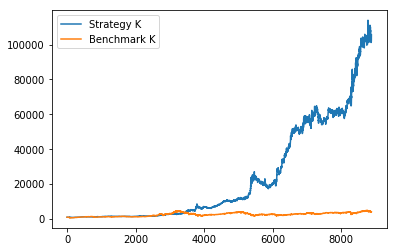

In [51]:
kpis_tosave=[]
columns=['INDICATOR', 'HITRATIO', 'EXPECTANCY', 'NTRADES', 'EARNINGS', 
                    'BENCHMARKEARNINGS', 'PROFITFACTOR', 'AVGPROFIT', 'AVGLOSS', 'SHARPERATIO', 
                    'BENCHSHARPERATIO', 'SORTINORATIO', 'BENCHSORTINORATIO', 'MAXDRAWDOWN', 'BENCHMAXDRAWDOWN',
                    'CALMARRATIO', 'BENCHCALMARRATIO'
                   ]

columns_t=['Sens', 'Entree', 'Sortie', 'Quantite', 'PandL', 'TakeProfit', 'StopLoss', 'ADX']

for index, row in dtickers.iterrows():

    df=getquote(row[0],".INDX", lastday)
    df=preprocess(df)
    
    doit=True
    if doit:
        print "DISTANCE EMA x PRICE"
        print ""

        print "EXPONENTIAL MOVING AVERAGES"
        print ""

        strat=[[10, 6, 10, 1, 9.5]]

        for x in strat:
            period_1=x[0]
            period_dist=x[1]
            adxx=x[2]
            risk=x[3]
            reward=x[4]
            
            df=exponential_moving_average(df,period_1)

            df['DIST_EMA_'+str(period_1)+'_'+str(period_dist)]=df['Adjusted_close']-df['EMA_'+str(period_1)]
            df['DIST_EMA_'+str(period_1)+'_'+str(period_dist)]=normalization(df,period_dist,'DIST_EMA_'+str(period_1)+'_'+str(period_dist))

            df=signal_4(df,'DIST_EMA_'+str(period_1)+'_'+str(period_dist))
            df.loc[df['ADX_14'] <= adxx, 'Signal'] = 0
            
            benchmark_c, trades, capital, benchmark, kpis=backtesting(df, risk, reward)
                    
            print 'DIST_EMA_'+str(period_1)+'_'+str(period_dist)+'_'+str(adxx)+'_'+str(risk)+'_'+str(reward)
            print kpis

            kpis.insert(0, 'DIST_EMA_'+str(period_1)+'_'+str(period_dist)+'_'+str(adxx)+'_'+str(risk)+'_'+str(reward))
            kpis_tosave.append(kpis)
    
    df_out = pd.DataFrame(kpis_tosave, columns=columns)
    writer = pd.ExcelWriter('STRATEGIES3_'+str(row[0])+'.xlsx', engine='xlsxwriter')
    df_out.to_excel(writer, sheet_name='STRATEGIES3', index=False)
    writer.save()
    
    df_out = pd.DataFrame(trades, columns=columns_t)
    writer = pd.ExcelWriter('TRADES_'+str(row[0])+'.xlsx', engine='xlsxwriter')
    df_out.to_excel(writer, sheet_name='TRADES', index=False)
    writer.save()

    plt.plot(capital, label = "Strategy K")
    plt.plot(benchmark, label = "Benchmark K")
    plt.legend()
    plt.show()


# Limites et Améliorations futures

Cet exercice a avant tout un objectif pédagogique et souffre donc de limites et d'améliorations.

La première limite est que notre système ne prend pas en charge les frais de transaction et les considère donc comme nuls par défaut. Leur absence en fait donc un système irréaliste. Leur ajout pourrait changer le résultat des stratégies retenues.

De plus, notre système actuel présente un fort risque d'overfitting surtout si nous y adjoignons des indicateurs qui doivent servir de filtres. Il en résulte qu'il est indispensable de séparer notre dataframe en 3 parties comme il est d'usage : l'une pour l'entrainement, l'autre pour la validation, la dernière pour le test.

Nous avons vu que l'ADX ne présente pas un grand intérêt comme filtre de nos stratégies retenues. Il serait intéressant de tester l'ADX comme indicateur secondaire pour chaque stratégie testée.

Par ailleurs, d'autres indicateurs que l'ADX peuvent être adjoints aux tests des différentes stratégies. Il peut être intéressant de mesurer la corrélation entre la valeur d'un indicateur servant de filtre et les résultats (échecs ou non) des trades relatifs à ces stratégies.
Le filtre ADX n'a été testé que pour un hyperparamètre de 14. Il peut être plus pertinent avec d'autres valeurs d'hyperparamètre.

En observant rapidement le graphique ci-dessus de l'évolution de notre capital de départ suivant notre stratégie retenue et la stratégie benchmark on se rend compte que notre stratégie semble presque identique au benchmark sur les 3 000 premières journées de notre dataframe. Ce fait doit nous alerter sur une étude plus précise de l'écart de performance entre cette période et la période suivante.

Enfin, dans la phase de test de l'ensemble des stratégies, les hyperparamètres de chaque indicateur ont été définis par moi-même ce qui induit un biais de sélection et rend très long et gourmand en ressources le processus de test. On pourrait améliorer cette phase en intégrant un algorithme d'optimisation des hyperparamètres (Génétique, Bayésien, TPE, PBT ou encore Hyperband).